# Line RT: 2D homogeneous
# circle symmetric, velocity gradient 

## 0) Setup

In [1]:
# Define Magritte folders

MagritteSetupFolder = '/home/frederik/Dropbox/Astro/Magritte/modules/setup/'
ProjectFolder       = '/home/frederik/MagritteProjects/Lines_3D_LTE/'

In [2]:
# Import tools and libraries

import numpy as np

from bokeh.plotting import figure, show, gridplot
from bokeh.palettes import cividis
from bokeh.io       import curdoc, output_notebook
from bokeh.themes   import built_in_themes
output_notebook()

from glob import glob
from sys  import path
path.insert(0, MagritteSetupFolder)

# Import from MagritteSetupFolder
from spheres  import deSphere, sphereVar
from lineData import LineData, planck, relativeDifference
from setup    import setupMagritte
from model    import model, mapToXD

Loading BokehJS ...

## 1) Define model

Assume a 1D model (i.e. 1 ray) with constant temperature, density and abundances and a linear velocity field, yielding a constant velocity gradient

\begin{align}
T(r)     \ &= \ cte, \\
\rho(r)  \ &= \ cte, \\
n_{i}(r) \ &= \ cte, \\
v(r)     \ &= \ cte,
\end{align}

where $L$ is the total length of the model and $v_{\max}$ is the maximum speed reached in the model. (Numerical values given below.) We write it in this way to ensure that velocities in the model are always much smaller than $c$, since our equations for Doppler shift are not valid otherwise.

There is CMB radiation incoming on both ends of the ray as boundary condition.

In [3]:
# Define model

model = model (dim=1)

model.ncells = 40

dens = 1.0E+12   # [m^-3]
abun = 1.0E+4    # [m^-3]
temp = 1.0E+02   # [K]
dx   = 1.0E4     # [m]
dT   = 0.0E0     # [K]
dv   = 1.0E1     # [m/s]

model.density     = [dens     for _ in range(model.ncells)]
model.abundance   = [abun     for _ in range(model.ncells)]
model.temperature = [temp     for _ in range(model.ncells)]

model.x = [dx*i  for i in range(model.ncells)]
model.y = [0.0   for _ in range(model.ncells)]
model.z = [0.0   for _ in range(model.ncells)]

model.vx = [dv*i for i in range(model.ncells)]
model.vy = [0.0  for _ in range(model.ncells)]
model.vz = [0.0  for _ in range(model.ncells)]

model.boundary = [0, model.ncells-1]

# Define nsidesList for mapping to 3D model
nraysList = [int(2.0*np.pi*i) for i in range(model.ncells)]

# Map 1D model to spherically symmetric 2D model
(model2D, cellsInShell) = mapToXD(model, dimension=2, nraysList=nraysList)

# Define rays
model2D.defineRays (nrays=50)

# Write new model data
model2D.writeInput (ProjectFolder + 'Magritte_files/')

# Run setup
setupMagritte (projectFolder = ProjectFolder, runName = '')

print(f'ncells in 2D model = {model2D.ncells}')
print(f'nrays  in 2D model = {model2D.nrays} ')

ncells in 2D model = 4882
nrays  in 2D model = 50 


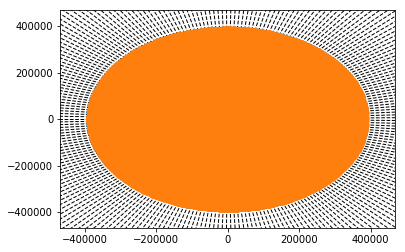

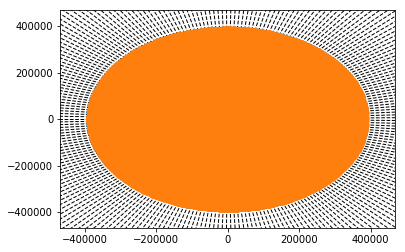

In [4]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
%matplotlib inline

points = [[model2D.x[p], model2D.y[p]] for p in range(model2D.ncells)]
vor    = Voronoi(points)

voronoi_plot_2d(vor)

In [5]:
# Plot model

plot_model_1 = figure (plot_width=400, plot_height=250, y_axis_type='log')
plot_model_1.line (model.x, model.density)
plot_model_1.xaxis.axis_label = "x [m]"
plot_model_1.yaxis.axis_label = "density [m^-3]"

plot_model_2 = figure (plot_width=400, plot_height=250, y_axis_type='log')
plot_model_2.line (model.x, model.abundance)
plot_model_2.xaxis.axis_label = "x [m]"
plot_model_2.yaxis.axis_label = "abundance [xm^-3]"

plot_model_3 = figure(plot_width=400, plot_height=250)
plot_model_3.line (model.x, model.temperature)
plot_model_3.xaxis.axis_label = "x [m]"
plot_model_3.yaxis.axis_label = "temperature [K]"

plot_model_4 = figure(plot_width=400, plot_height=250)
plot_model_4.line (model.x, model.vx)
plot_model_4.xaxis.axis_label = "x [m]"
plot_model_4.yaxis.axis_label = "velocity_x [m^-3]"

plot_model = gridplot ([[plot_model_1, plot_model_2],[plot_model_3, plot_model_4]])

show (plot_model)

### Read Magritte output

In [6]:
# Read Magritte output

ioFolders = glob(ProjectFolder + 'io/*/')
ioFolders.sort()

inputFolders  = [folder +  'input/' for folder in ioFolders]
outputFolders = [folder + 'output/' for folder in ioFolders]

lastOutput = outputFolders[-1]
lastInput  =  inputFolders[-1]

pops_files = glob(lastOutput + 'populations_0*.txt')
Jeff_files = glob(lastOutput + 'Jeff_0*.txt')
J_files    = glob(lastOutput + 'J_*.txt')
G_files    = glob(lastOutput + 'G_*.txt')
nu_files   = glob(lastOutput + 'frequencies_nu*.txt')
lnr_files  = glob(lastOutput + 'frequencies_line_nr*.txt')
eta_files  = glob(lastOutput + 'eta_0*.txt')
chi_files  = glob(lastOutput + 'chi_0*.txt')

pops_files.sort()
Jeff_files.sort()
eta_files.sort()
chi_files.sort()

pops_2D_data = [np.loadtxt(fileName) for fileName in pops_files]
Jeff_2D_data = [np.loadtxt(fileName) for fileName in Jeff_files]
J_2D_data    = [np.loadtxt(fileName) for fileName in J_files]
G_2D_data    = [np.loadtxt(fileName) for fileName in G_files]
nu_2D_data   = [np.loadtxt(fileName) for fileName in nu_files]
lnr_2D_data  = [np.loadtxt(fileName) for fileName in lnr_files]
eta_2D_data  = [np.loadtxt(fileName) for fileName in eta_files]
chi_2D_data  = [np.loadtxt(fileName) for fileName in chi_files]

# Import linedata
lineData = LineData (ProjectFolder + '/Magritte_files/linedata/hco+.dat')

## Image model

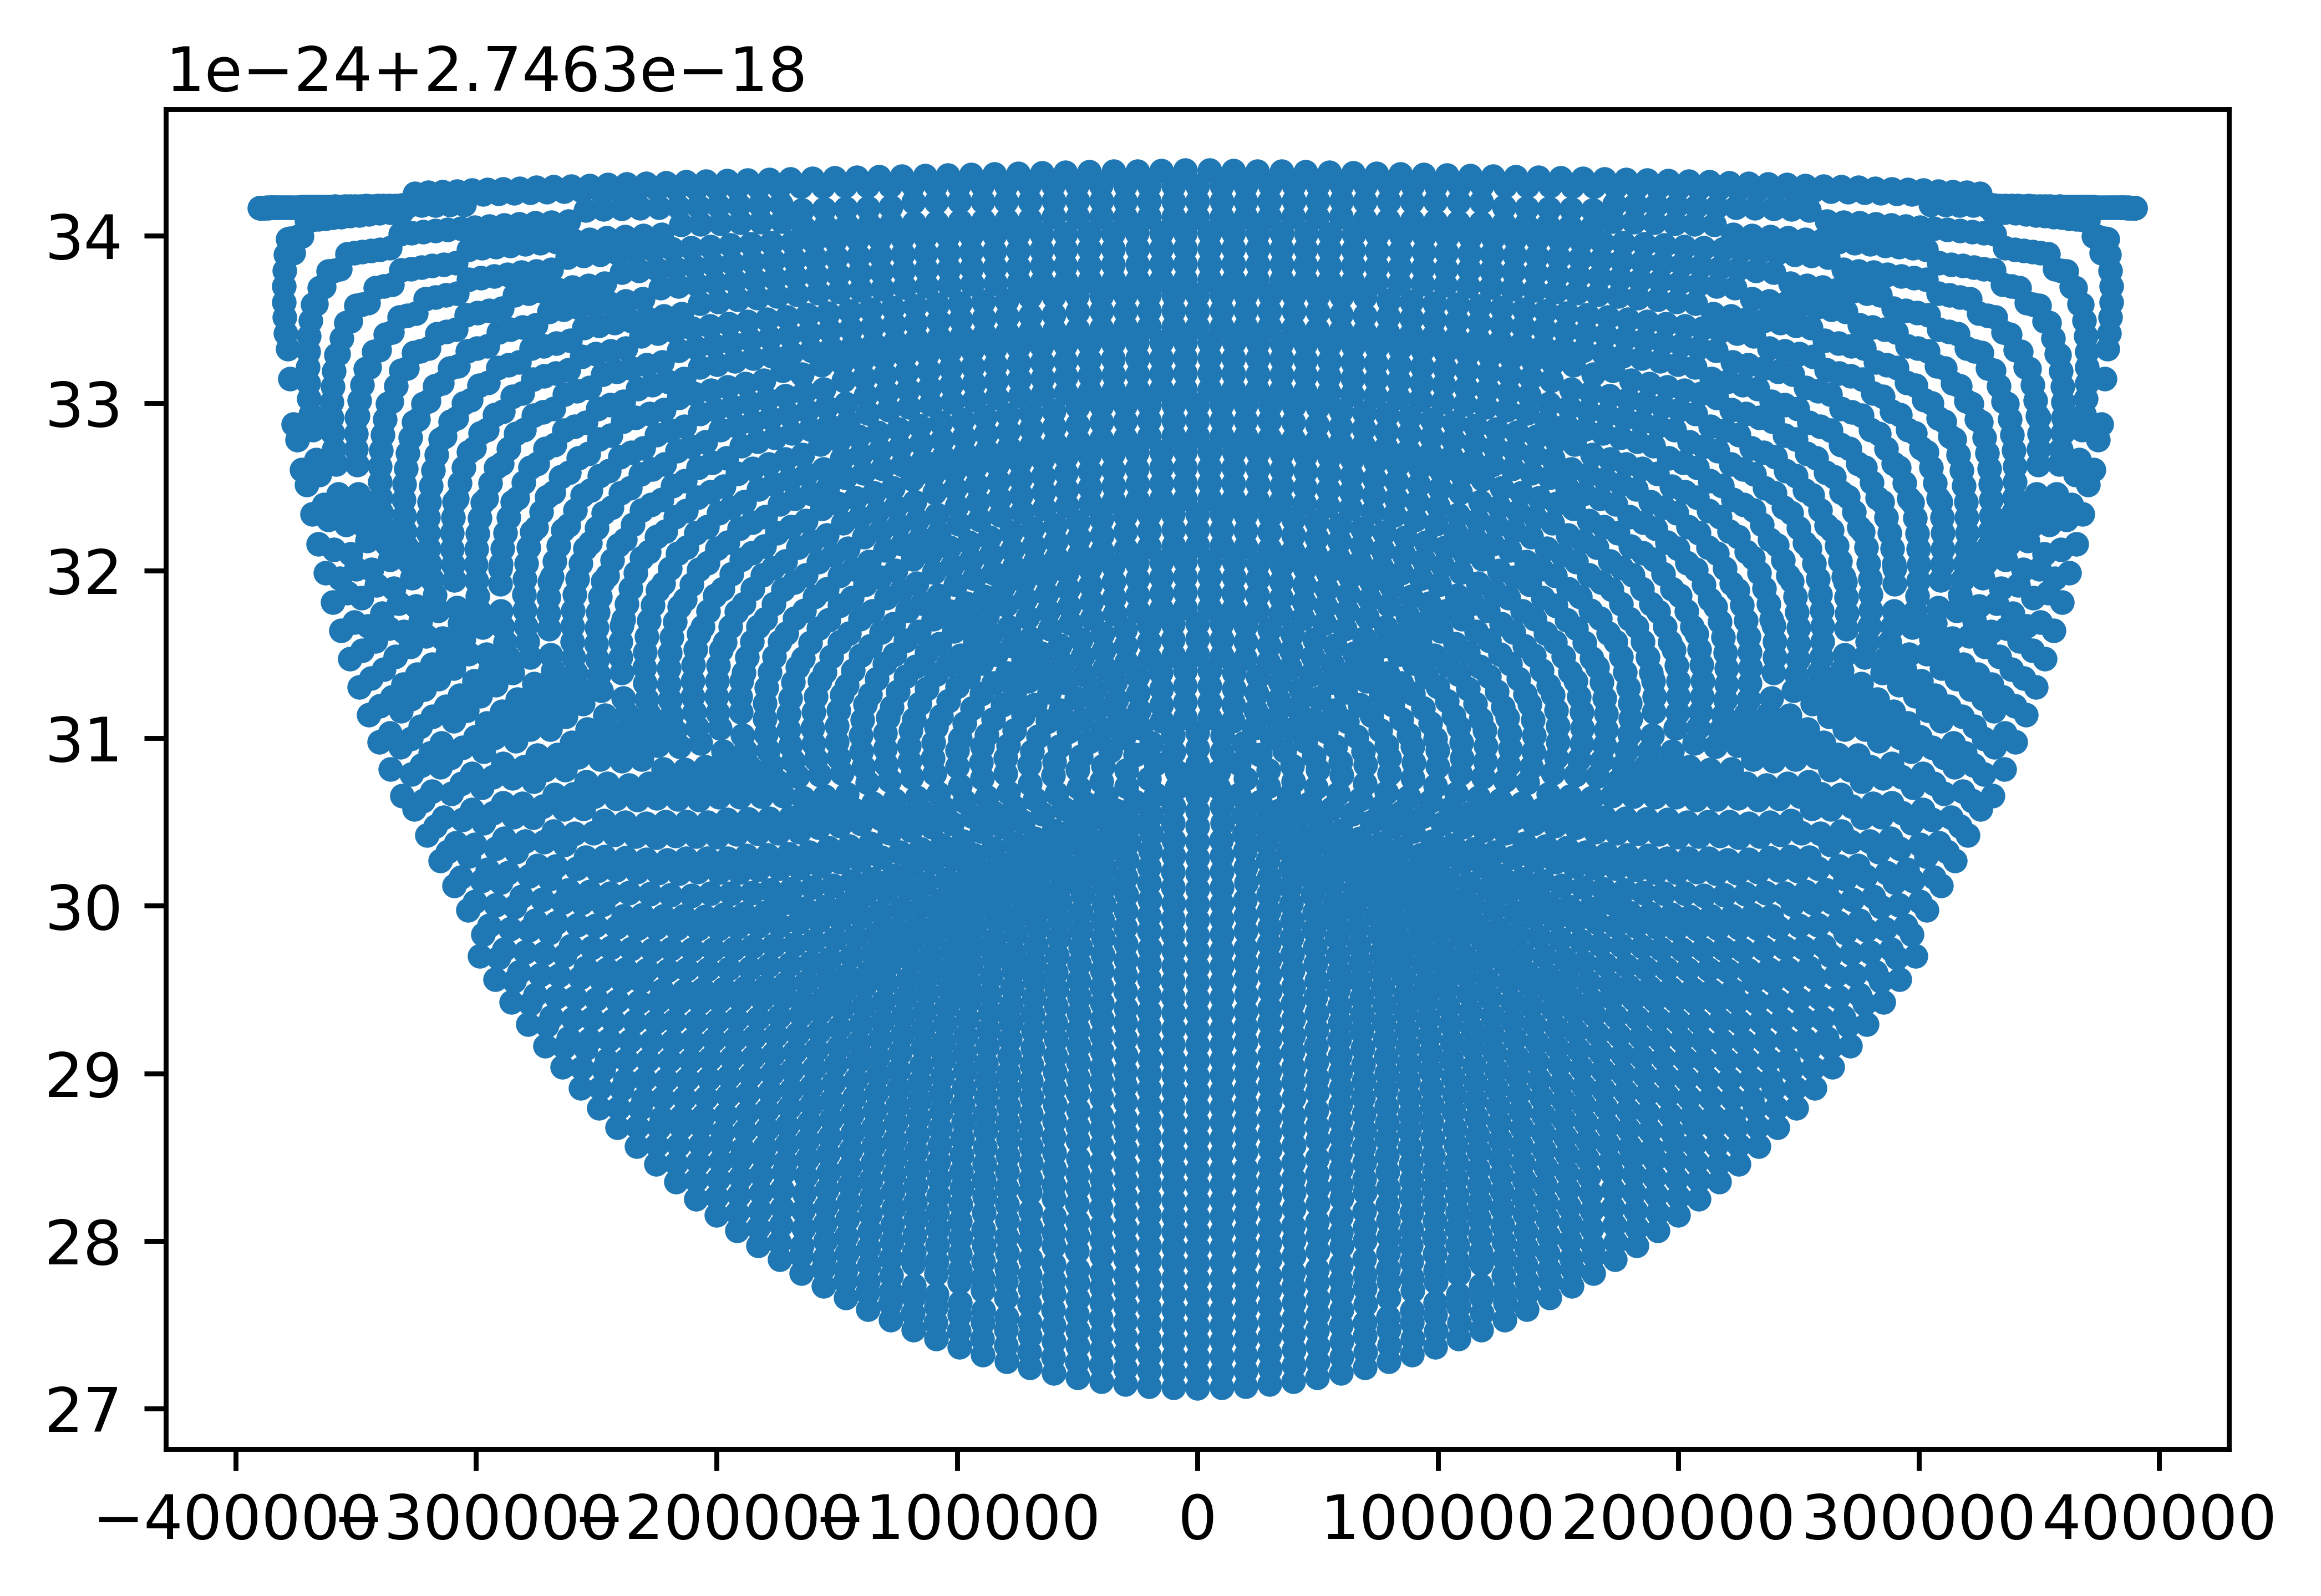

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

data = np.loadtxt(lastOutput + 'image_p_0.txt')

f = 20

imdata = data[:,f]

model2D.imageRay(0)
x = model2D.imageX

plt.figure(dpi=800)
plt.plot(x,imdata, '.')

### Map sphere to 1D model

In [8]:
# Map shpere to 1D model

pops_data = deSphere(cellsInShell, pops_3D_data)
pops_var  = sphereVar(cellsInShell, pops_3D_data)

J_data = deSphere(cellsInShell, J_3D_data)
J_var  = sphereVar(cellsInShell, J_3D_data)

G_data = deSphere(cellsInShell, G_3D_data)
G_var  = sphereVar(cellsInShell, G_3D_data)

Jeff_data = deSphere(cellsInShell, Jeff_3D_data)
Jeff_var  = sphereVar(cellsInShell, Jeff_3D_data)

nu_data = deSphere(cellsInShell, nu_3D_data)
nu_var  = sphereVar(cellsInShell, nu_3D_data)

lnr_data = deSphere(cellsInShell, lnr_3D_data)
lnr_var  = sphereVar(cellsInShell, lnr_3D_data)

#etaR   = deSphere(cellsInShell, eta_data)
#etaVar = sphereVar(cellsInShell, eta_data)

#chiR   = deSphere(cellsInShell, chi_data)
#chiVar = sphereVar(cellsInShell, chi_data)

for s in range(model.ncells):
    #print(f'pops_var  = {np.max(pops_var[0][s])}')
    #print(f'Jeff_var  = {np.max(Jeff_var[0][s])}')
    print(f'J_var     = {np.max(J_var[0][s])}')
    #print(f'nu_var    = {np.max(nu_var[0][s])}')
    #print(f'lnr_var   = {np.max(lnr_var[0][s])}')

#print(np.max(etaVar))
#print(np.max(chiVar))

J_var     = 0.0
J_var     = 9.986059387940502e-06
J_var     = 4.833157011819859e-05
J_var     = 5.700761981055558e-05
J_var     = 3.202144522019273e-05
J_var     = 6.963687099833138e-05
J_var     = 7.493841257182144e-05
J_var     = 0.00011337300287220008
J_var     = 0.00014359347261857328
J_var     = 0.00012702160709561093
J_var     = 0.00015989280431644715
J_var     = 0.00015065894572064163
J_var     = 0.00013748051167021067
J_var     = 0.00018143343851723549
J_var     = 0.00016150529574635427
J_var     = 0.0001580346033062131
J_var     = 0.00013537191366292428
J_var     = 0.00022755338251213855
J_var     = 0.00026665165510163176
J_var     = 0.0002790943458944256
J_var     = 0.0002346033658104429
J_var     = 0.00019918556902077022
J_var     = 0.0002811571081925455
J_var     = 0.00025173726791699884
J_var     = 0.00026724238013126306
J_var     = 0.00020147616035157205
J_var     = 0.00033558600586810355
J_var     = 0.00035495736087759374
J_var     = 0.00032715755216069115
J_var     = 0.

### Plot output

In [9]:
# Plot functions

def color(s):
    ns = int((s_max-s_min) / s_step + 1)
    es = int((s    -s_min) / s_step)
    return cividis(ns)[es]

def legend(s):
    return f'{s}'

def bokeh_log_plot(title, x, y, xlabel, ylabel):
    return

In [10]:
s_min  = 0
s_max  = model.ncells
s_step = 1

In [11]:
# Level populations

plot = figure (title='Level populations', width=700, height=400, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = range(lineData.nlev)
    y = pops_data[0][s]
    plot.line (x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "number of the level"
plot.yaxis.axis_label = "population [m^-3]"
show (plot)

In [12]:
# Mean intensity

plot = figure (title='Total mean intensity', width=700, height=400, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = range(lineData.nrad)
    y = Jeff_data[1][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "number of the transition"
plot.yaxis.axis_label = "mean intensity J [m^-3]"
show(plot)

In [13]:
# Spectrum

plot = figure (title='Spectrum', width=700, height=500, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = nu_data[0][s]
    y =  J_data[0][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "frequencies [Hz]"
plot.yaxis.axis_label = "Mean intensity [W/m^2]"
show(plot)

In [14]:
# Flux (G) spectrum

plot = figure (title='Spectrum', width=700, height=500)
for s in range(s_min, s_max, s_step):
    x = nu_data[0][s]
    y =  G_data[0][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "frequencies [Hz]"
plot.yaxis.axis_label = "Mean intensity [W/m^2]"
show(plot)

## Analytical solution

Set the number of the line to model

In [15]:
line = 17

In [16]:
# Analytical model

import scipy.integrate as integrate

# Constants

c     = 2.99792458E+8    # [m/s] speed of light
kb    = 1.38064852E-23   # [J/K] Boltzmann's constant
mp    = 1.6726219E-27    # [kg] proton mass
T_CMB = 2.7254800        # [K] CMB temperature
vturb = 0.12012E3        # [m/s] turbulent speed

inverse_sqrt_pi = 0.5641895835478

pops       = lineData.LTEpop(temp) * abun
emissivity = lineData.lineEmissivity(pops)
opacity    = lineData.lineOpacity(pops)
source     = emissivity / opacity

def bcd (nu):
    return planck(T_CMB, nu)

S     = source[line]
chi   = opacity[line]
R     = model.x[-1]
v_max = model.vx[-1]
nuij  = lineData.frequency[line]
dnu   = nuij/c * np.sqrt(2.0*kb*temp/mp + vturb**2)


We assume a Gaussian line profile function

\begin{equation}
	\phi_{\nu}^{ij}(x) \ = \ \frac{1}{\sqrt{\pi} \ \delta\nu_{ij}} \ \exp \left[-\left(\frac{\nu-\nu_{ij}} {\delta\nu_{ij}}\right)^{2}\right],
\end{equation}

where the profile width is constant and given by

\begin{equation}
    \delta\nu_{ij} \ = \ \frac{\nu_{ij}}{c} \sqrt{ \frac{2 k_{b} T}{m_{\text{spec}}} \ + \ v_{\text{turb}}^{2}}.
\end{equation}

In [17]:
def phi(nu):
    return inverse_sqrt_pi / dnu * np.exp(-((nu-nuij)/dnu)**2)

Assume furthermore a linear velocity distribution (with the velocity expressed as a fraction of the speed of light $c$).

\begin{equation}
v(r) \ = \ \frac{v_{\max} r}{c R}
\end{equation}

In [28]:
def v(r):
    return v_max*r / (c*R)

In a sphere of radius $R$, on a distance $r$ from the center, the distance $z$ to the boundary in a direction under an angle $\theta$ with the position vector $\textbf{r}$ is

\begin{equation}
z_{\max}(r,\theta) \ = \ r \cos \theta + \sqrt{R^{2} - r^{2} \sin^{2} \theta} .
\end{equation}

In [29]:
def z_max(r, theta):
    return r * np.cos(theta) + np.sqrt(R**2 - (r*np.sin(theta))**2)

/home/frederik/software/anaconda3/envs/magritte/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


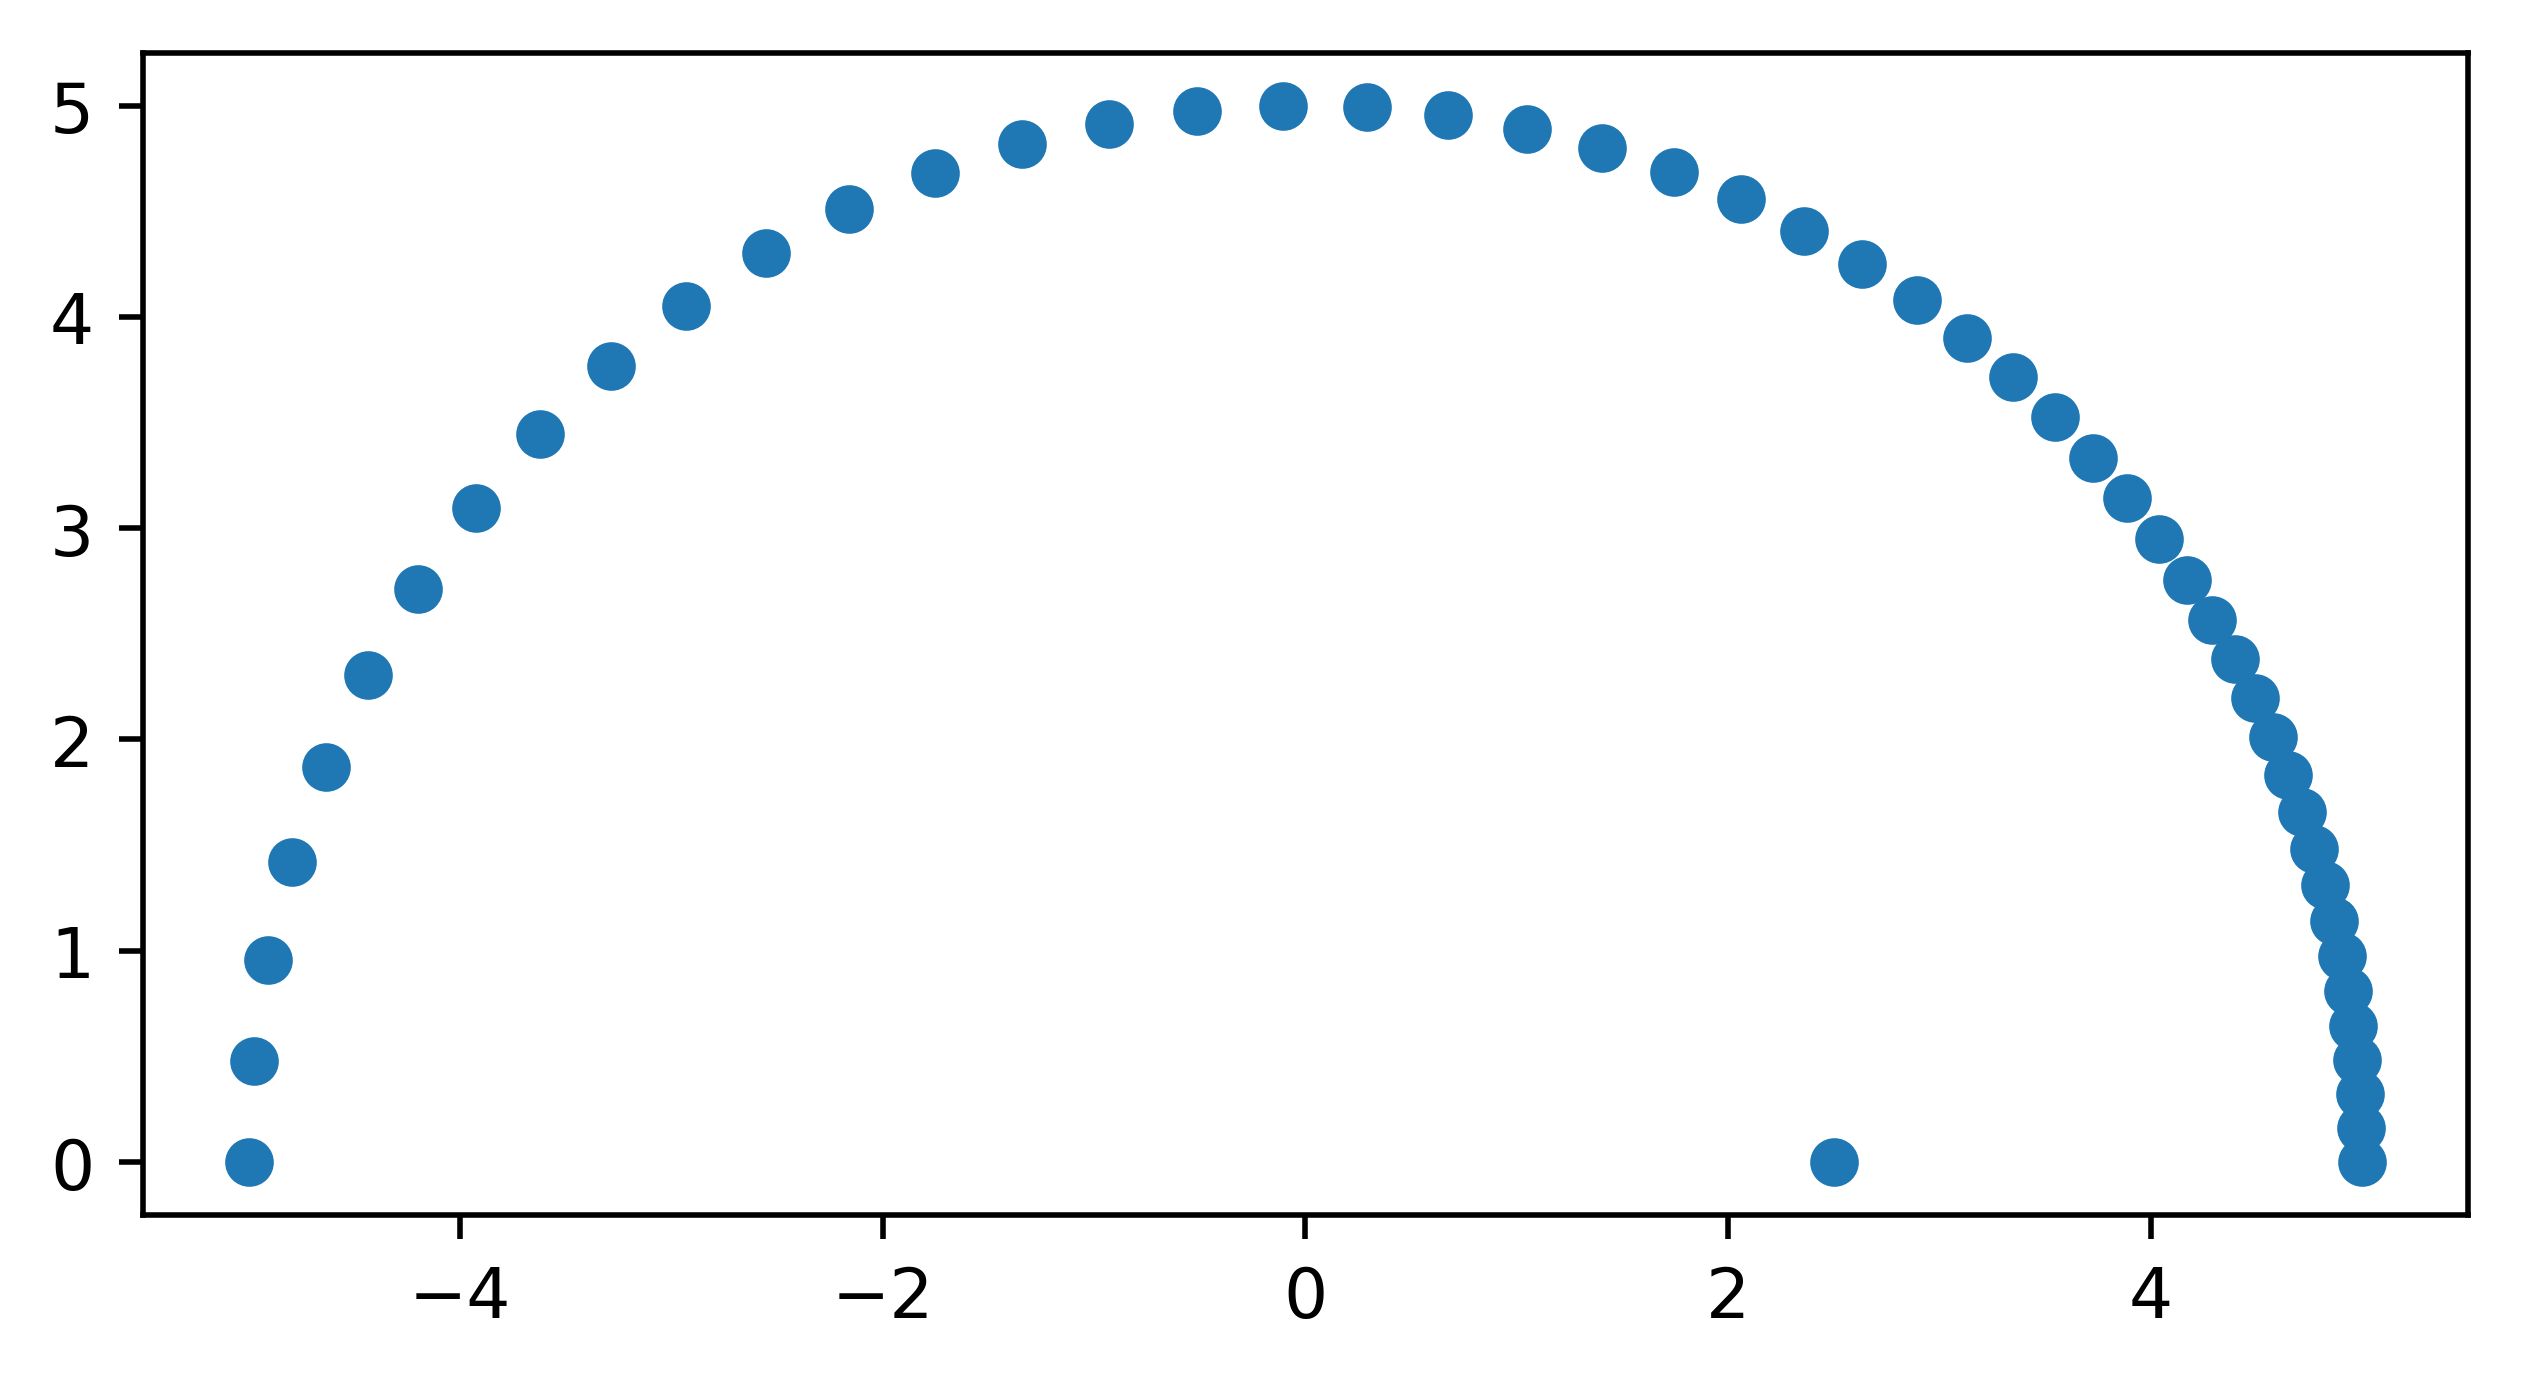

In [168]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# r = 0.5*R

# x = [r]
# y = [0.0]

# for theta in np.linspace(0, np.pi, 50):
#     x += [r + z_max(r, theta)*np.cos(theta)]
#     y += [    z_max(r, theta)*np.sin(theta)]
# plt.figure(dpi=500)
# plt.scatter(x,y)
# plt.axes().set_aspect('equal')

\begin{equation}
r'(r,\theta, z) \ = \ \sqrt{r^{2} + z^{2} - 2 r z \cos \theta} .
\end{equation}

In [30]:
def r_p(r, theta, z):
    return np.sqrt(r**2 + z**2 - 2.0*r*z*np.cos(theta))

The angle $\alpha$ between the velocity vector in $\textbf{r}$ and $\textbf{r'}$ can be found from

\begin{equation}
\cos \alpha \ = \ \frac{r - z \cos \theta}{r'(r,\theta, z)} .
\end{equation}

In [31]:
def cos_a(r, theta, z):
    return (r - z*np.cos(theta)) / r_p(r, theta, z)

The velocity difference encountered along the line of sight is

\begin{equation}
    \| \Delta \textbf{v} \| \ = \ \sqrt{ v(r)^{2} + v(r')^{2} - 2 v(r) v(r') \cos \alpha }, 
\end{equation}

and hence the resulting Doppler shifted frequency is

\begin{equation}
    \frac{\nu'(z)}{\nu} \ = \ \frac{1}{c} \left(c - \ \sqrt{ v(r)^{2} + v(r')^{2} - 2 v(r) v(r') \cos \alpha }\right) .
\end{equation}

In [32]:
def shift(r, theta, z):
    vr = v(r)
    vp = v(r_p(r, theta, z))
    return 1.0 - np.sqrt(vr**2 + vp**2 - vr*vp*cos_a(r, theta, z))

The optical depth $\tau_{\nu}$ along a ray is given by

\begin{equation}
    \tau_{\nu}(r,\theta) \ = \  \frac{\chi_{ij}}{\sqrt{\pi} \ \delta\nu_{ij}} \int_{0}^{z_{\max}} \text{d} z \ \exp \left[-\left(\frac{\nu'(r, \theta, z)-\nu_{ij}} {\delta\nu_{ij}}\right)^{2}\right].
\end{equation}

In [33]:
def tau(nu, r, theta):
    return chi * integrate.quad (lambda z: phi(nu*shift(r, theta, z)), 0, z_max(r, theta))[0]

#def tau(nu, r, theta):
#    return chi * phi(nu) * z_max(r, theta)

The mean intensity is given by

\begin{equation}
J_{\nu}(r) \ = \ S_{\nu} \ + \ \left(B_{\nu}-S_{\nu}\right) \ \int_{0}^{\pi} \frac{\text{d} \theta}{\pi} \ e^{-\tau_{\nu}(r,\theta)},
\end{equation}

In [34]:
def J(nu, r):
    B = bcd (nu)
    return S + (B-S) / np.pi * integrate.quad (lambda theta: np.exp(-tau(nu, r, theta)), 0, np.pi)[0]

The "mean flux" is given by

\begin{equation}
G_{\nu}(r) \ = \ - \left(B_{\nu}-S_{\nu}\right) \ \int_{0}^{\pi} \frac{\text{d} \theta}{\pi} \ e^{-\tau_{\nu}(r,\theta)},
\end{equation}

In [35]:
def G(nu, r):
    B = bcd (nu)
    return   - (B-S) / np.pi * integrate.quad (lambda theta: np.exp(-tau(nu, r, theta)), 0, np.pi)[0]

In [36]:
def relativeError(a,b):
    return 2.0 * np.abs((a-b)/(a+b))

In [37]:
# Line

plot_model = figure(title='Line model', width=400, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    M = int(lnr_data[0][s][line] - 18    )
    N = int(lnr_data[0][s][line] + 18 + 1)
    # model
    x = nuij + 8 * dnu * np.linspace(-1,1,500)
    y = [J(xi, model.x[s]) for xi in x]
    plot_model.line(x, y, color=color(s))
    # data
    x = nu_data[0][s][M:N]
    y =  J_data[0][s][M:N]
    plot_model.circle(x, y, color=color(s), legend=legend(s))

plot_error = figure(title='Line error', width=400, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    M = int(lnr_data[0][s][line] - 18    )
    N = int(lnr_data[0][s][line] + 18 + 1)
    # error
    x = nu_data[0][s][M:N]
    y = relativeError([J(xi, model.x[s]) for xi in x], J_data[0][s][M:N])
    plot_error.circle(x, y, color=color(s), legend=legend(s))

plot = gridplot([[plot_model, plot_error]])

show(plot)

In [159]:
plot_line_model = figure(title='Line model: space dependence', width=450, height=400, y_axis_type="log")
#for s in range(s_min, s_max, 2):
# model
xx = np.array(model.x)
plot_line_model.line(xx, J(nuij,xx))
# data
M = int(lnr_data[0][0][line])
plot_line_model.circle(xx, J_data[0][:,M])
plot_line_model.xaxis.axis_label = "x [m]"
plot_line_model.yaxis.axis_label = "Mean intensity [W/m^2]"

plot_line = gridplot([[plot_line_model, plot_line_error]])

show (plot_line)

TypeError: only size-1 arrays can be converted to Python scalars

In [26]:
plot_line_model = figure(title='Line model', width=450, height=400, y_axis_type="log")
#for s in range(s_min, s_max, 2):
# model
xx = np.array(model.x)
plot_line_model.line(xx, J(nuij,xx))
# data
M = int(lnr_data[0][0][line])
plot_line_model.circle(xx, Jeff_data[0][:,line])

plot_line = gridplot([[plot_line_model, plot_line_error]])

show (plot_line)

In [7]:
for a in range(-4):
    print(a)